# Model trained on dataset Lall

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import copy

### Data loading

In [3]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_Lall.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_L.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_L.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


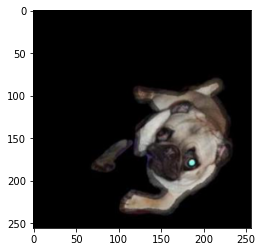

In [4]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

### Helper functions

In [5]:
def model_dict(model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    Returns a dictionary with a deep copy of the model in its current state and the associated accuracy metrics.
    """
    
    return {'current_model': copy.deepcopy(model), 'current_iter':copy.deepcopy(iteration), 'current_train_acc':copy.deepcopy(current_train_accuracy), 'current_valid_acc':copy.deepcopy(current_valid_accuracy)}

def add_to_saved_models(saved_models,length,model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    saved_models is a list of specified length where we save the deep copies of the model at different training stages with the best validation accuracies.
    
    This function adds a dictionary created by model_dict(...) defined above either if the list of saved_models is not full yet, or if the current version of the model is better than the worst one already saved in the list.
    """
    
    dic = model_dict(model,iteration,current_train_accuracy,current_valid_accuracy)
    
    if len(saved_models)<length:
        saved_models.append(dic)
    else:
        valid_acc_list = [dictionary['current_valid_acc'] for dictionary in saved_models]
        min_valid_acc = min(valid_acc_list)
        min_valid_index = valid_acc_list.index(min_valid_acc)
        
        if dic['current_valid_acc'] > min_valid_acc:
            saved_models[min_valid_index] = dic

### Model and training

In [6]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    

model = PetCNN6()
loss_function = nn.NLLLoss()

    
saved_models = []

learning_rate = 0.001
wt_decay = 0.0003
lr_decay = 0.95    

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=wt_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=lr_decay)

num_epochs = 200

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()


for epoch in range(num_epochs):
    for images, labels in train_loader:
        model.train()
        out = model(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%25==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 25 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    
            
            
            if epoch>0:     
                
                model.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=1024,shuffle=True)  
                    images_c, labels_c = next(iter(train_part))
                    train_out = model(images_c.float())    
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/1024
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)
                    
                    if current_valid_accuracy > 0.43:
                        add_to_saved_models(saved_models,5,model,iteration,current_train_accuracy,current_valid_accuracy)
                        

                
            start = time.time()
            
    scheduler.step()
                

        

    


Epoch:0
Iteration:25
Time taken for the last 25 iterations: 16.048754692077637
Current learning rate:0.001
Epoch:0
Iteration:50
Time taken for the last 25 iterations: 16.943795919418335
Current learning rate:0.001
Epoch:0
Iteration:75
Time taken for the last 25 iterations: 20.122715950012207
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 25 iterations: 21.427061557769775
Current learning rate:0.001
Epoch:0
Iteration:125
Time taken for the last 25 iterations: 22.404151439666748
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 25 iterations: 18.30988073348999
Current learning rate:0.001
Epoch:0
Iteration:175
Time taken for the last 25 iterations: 20.778276681900024
Current learning rate:0.001
Epoch:1
Iteration:200
Time taken for the last 25 iterations: 19.717259407043457
Current learning rate:0.001
Current training loss:3.543616771697998
Current training accuracy:0.044921875
Current validation loss:3.5574371814727783
Current validation 

Epoch:4
Iteration:875
Time taken for the last 25 iterations: 17.76631236076355
Current learning rate:0.001
Current training loss:3.1664838790893555
Current training accuracy:0.1337890625
Current validation loss:3.2612030506134033
Current validation accuracy:0.11099020391702652
Epoch:4
Iteration:900
Time taken for the last 25 iterations: 17.746283531188965
Current learning rate:0.001
Current training loss:3.117084503173828
Current training accuracy:0.154296875
Current validation loss:3.173985242843628
Current validation accuracy:0.14472252130508423
Epoch:4
Iteration:925
Time taken for the last 25 iterations: 17.819477081298828
Current learning rate:0.001
Current training loss:3.139133930206299
Current training accuracy:0.1474609375
Current validation loss:3.257439613342285
Current validation accuracy:0.1273123025894165
Epoch:5
Iteration:950
Time taken for the last 25 iterations: 17.341481924057007
Current learning rate:0.00095
Current training loss:3.0672249794006348
Current training ac

Current training loss:2.805110216140747
Current training accuracy:0.2265625
Current validation loss:2.9250693321228027
Current validation accuracy:0.1969532072544098
Epoch:8
Iteration:1625
Time taken for the last 25 iterations: 17.793534517288208
Current learning rate:0.00095
Current training loss:2.839592218399048
Current training accuracy:0.20703125
Current validation loss:2.9651660919189453
Current validation accuracy:0.19477693736553192
Epoch:8
Iteration:1650
Time taken for the last 25 iterations: 17.62886929512024
Current learning rate:0.00095
Current training loss:2.8067476749420166
Current training accuracy:0.220703125
Current validation loss:2.8955225944519043
Current validation accuracy:0.20674645900726318
Epoch:9
Iteration:1675
Time taken for the last 25 iterations: 17.298554182052612
Current learning rate:0.00095
Current training loss:2.852607011795044
Current training accuracy:0.20703125
Current validation loss:2.9612693786621094
Current validation accuracy:0.16213275492191

Current validation loss:2.7862210273742676
Current validation accuracy:0.21327529847621918
Epoch:12
Iteration:2350
Time taken for the last 25 iterations: 17.622923374176025
Current learning rate:0.0009025
Current training loss:2.5727462768554688
Current training accuracy:0.2705078125
Current validation loss:2.6861300468444824
Current validation accuracy:0.25244832038879395
Epoch:12
Iteration:2375
Time taken for the last 25 iterations: 17.63517689704895
Current learning rate:0.0009025
Current training loss:2.497001886367798
Current training accuracy:0.2978515625
Current validation loss:2.6655611991882324
Current validation accuracy:0.24156692624092102
Epoch:12
Iteration:2400
Time taken for the last 25 iterations: 17.649958610534668
Current learning rate:0.0009025
Current training loss:2.4834482669830322
Current training accuracy:0.3125
Current validation loss:2.667922019958496
Current validation accuracy:0.24918389320373535
Epoch:13
Iteration:2425
Time taken for the last 25 iterations: 

Current validation loss:2.5721523761749268
Current validation accuracy:0.2752992510795593
Epoch:16
Iteration:3075
Time taken for the last 25 iterations: 17.85548186302185
Current learning rate:0.000857375
Current training loss:2.431516408920288
Current training accuracy:0.3212890625
Current validation loss:2.5912461280822754
Current validation accuracy:0.26877039670944214
Epoch:16
Iteration:3100
Time taken for the last 25 iterations: 17.712462425231934
Current learning rate:0.000857375
Current training loss:2.351919174194336
Current training accuracy:0.3466796875
Current validation loss:2.5280921459198
Current validation accuracy:0.28618064522743225
Epoch:16
Iteration:3125
Time taken for the last 25 iterations: 17.5207736492157
Current learning rate:0.000857375
Current training loss:2.337251901626587
Current training accuracy:0.3291015625
Current validation loss:2.5475223064422607
Current validation accuracy:0.2676822543144226
Epoch:16
Iteration:3150
Time taken for the last 25 iteratio

Current validation loss:2.370466947555542
Current validation accuracy:0.31229597330093384
Epoch:20
Iteration:3800
Time taken for the last 25 iterations: 17.693669319152832
Current learning rate:0.0008145062499999999
Current training loss:2.237037420272827
Current training accuracy:0.3916015625
Current validation loss:2.4390950202941895
Current validation accuracy:0.3112078309059143
Epoch:20
Iteration:3825
Time taken for the last 25 iterations: 18.84928274154663
Current learning rate:0.0008145062499999999
Current training loss:2.1705408096313477
Current training accuracy:0.3876953125
Current validation loss:2.3696560859680176
Current validation accuracy:0.3177366554737091
Epoch:20
Iteration:3850
Time taken for the last 25 iterations: 17.908718585968018
Current learning rate:0.0008145062499999999
Current training loss:2.144897222518921
Current training accuracy:0.4287109375
Current validation loss:2.3745310306549072
Current validation accuracy:0.3242655098438263
Epoch:20
Iteration:3875
T

Current validation loss:2.275048017501831
Current validation accuracy:0.3514689803123474
Epoch:24
Iteration:4500
Time taken for the last 25 iterations: 17.641308784484863
Current learning rate:0.0008145062499999999
Current training loss:2.0027098655700684
Current training accuracy:0.455078125
Current validation loss:2.2744007110595703
Current validation accuracy:0.3351469039916992
Epoch:24
Iteration:4525
Time taken for the last 25 iterations: 17.722135066986084
Current learning rate:0.0008145062499999999
Current training loss:1.9904768466949463
Current training accuracy:0.44140625
Current validation loss:2.301485061645508
Current validation accuracy:0.3503808379173279
Epoch:24
Iteration:4550
Time taken for the last 25 iterations: 17.714105129241943
Current learning rate:0.0008145062499999999
Current training loss:1.9595500230789185
Current training accuracy:0.44921875
Current validation loss:2.279971122741699
Current validation accuracy:0.33297061920166016
Epoch:24
Iteration:4575
Time 

Current validation loss:2.1912572383880615
Current validation accuracy:0.3743199110031128
Epoch:27
Iteration:5200
Time taken for the last 25 iterations: 17.59051012992859
Current learning rate:0.0007737809374999998
Current training loss:1.7975337505340576
Current training accuracy:0.5166015625
Current validation loss:2.1830737590789795
Current validation accuracy:0.36343851685523987
Epoch:28
Iteration:5225
Time taken for the last 25 iterations: 17.217158317565918
Current learning rate:0.0007737809374999998
Current training loss:1.85343599319458
Current training accuracy:0.4873046875
Current validation loss:2.211148262023926
Current validation accuracy:0.3482045829296112
Epoch:28
Iteration:5250
Time taken for the last 25 iterations: 17.65304946899414
Current learning rate:0.0007737809374999998
Current training loss:1.8844839334487915
Current training accuracy:0.46484375
Current validation loss:2.185584306716919
Current validation accuracy:0.3688792288303375
Epoch:28
Iteration:5275
Time 

Current validation loss:2.106982707977295
Current validation accuracy:0.3884657323360443
Epoch:31
Iteration:5900
Time taken for the last 25 iterations: 17.771238327026367
Current learning rate:0.0007350918906249997
Current training loss:1.694911003112793
Current training accuracy:0.537109375
Current validation loss:2.1643946170806885
Current validation accuracy:0.3710554838180542
Epoch:31
Iteration:5925
Time taken for the last 25 iterations: 17.896165370941162
Current learning rate:0.0007350918906249997
Current training loss:1.7861378192901611
Current training accuracy:0.5283203125
Current validation loss:2.150557279586792
Current validation accuracy:0.367791086435318
Epoch:31
Iteration:5950
Time taken for the last 25 iterations: 17.871790409088135
Current learning rate:0.0007350918906249997
Current training loss:1.6874947547912598
Current training accuracy:0.5498046875
Current validation loss:2.100008249282837
Current validation accuracy:0.3873775899410248
Epoch:32
Iteration:5975
Time

Current validation loss:2.104414701461792
Current validation accuracy:0.38628944754600525
Epoch:35
Iteration:6600
Time taken for the last 25 iterations: 17.822096347808838
Current learning rate:0.0006983372960937497
Current training loss:1.6732852458953857
Current training accuracy:0.572265625
Current validation loss:2.1019272804260254
Current validation accuracy:0.4015233814716339
Epoch:35
Iteration:6625
Time taken for the last 25 iterations: 17.838794469833374
Current learning rate:0.0006983372960937497
Current training loss:1.5657414197921753
Current training accuracy:0.5830078125
Current validation loss:2.1093592643737793
Current validation accuracy:0.39281827211380005
Epoch:35
Iteration:6650
Time taken for the last 25 iterations: 17.806127786636353
Current learning rate:0.0006983372960937497
Current training loss:1.6382540464401245
Current training accuracy:0.541015625
Current validation loss:2.1454594135284424
Current validation accuracy:0.3841131627559662
Epoch:35
Iteration:6675

Current validation loss:2.0571413040161133
Current validation accuracy:0.3917301297187805
Epoch:39
Iteration:7300
Time taken for the last 25 iterations: 17.84354257583618
Current learning rate:0.0006983372960937497
Current training loss:1.5226331949234009
Current training accuracy:0.6396484375
Current validation loss:2.0669548511505127
Current validation accuracy:0.4080522358417511
Epoch:39
Iteration:7325
Time taken for the last 25 iterations: 17.742867469787598
Current learning rate:0.0006983372960937497
Current training loss:1.5734320878982544
Current training accuracy:0.6005859375
Current validation loss:2.0861854553222656
Current validation accuracy:0.41349291801452637
Epoch:39
Iteration:7350
Time taken for the last 25 iterations: 17.778470039367676
Current learning rate:0.0006983372960937497
Current training loss:1.5022988319396973
Current training accuracy:0.6142578125
Current validation loss:2.0641684532165527
Current validation accuracy:0.40261152386665344
Epoch:39
Iteration:73

Current validation loss:2.073664665222168
Current validation accuracy:0.38955387473106384
Epoch:43
Iteration:8000
Time taken for the last 25 iterations: 17.3246648311615
Current learning rate:0.0006634204312890621
Current training loss:1.5413284301757812
Current training accuracy:0.591796875
Current validation loss:2.067890167236328
Current validation accuracy:0.41349291801452637
Epoch:43
Iteration:8025
Time taken for the last 25 iterations: 17.913166999816895
Current learning rate:0.0006634204312890621
Current training loss:1.4683183431625366
Current training accuracy:0.640625
Current validation loss:2.100555181503296
Current validation accuracy:0.3808487355709076
Epoch:43
Iteration:8050
Time taken for the last 25 iterations: 17.82729935646057
Current learning rate:0.0006634204312890621
Current training loss:1.4533482789993286
Current training accuracy:0.61328125
Current validation loss:2.06673526763916
Current validation accuracy:0.3949945569038391
Epoch:43
Iteration:8075
Time taken 

Current validation loss:2.03082275390625
Current validation accuracy:0.4113166630268097
Epoch:46
Iteration:8700
Time taken for the last 25 iterations: 17.848042488098145
Current learning rate:0.000630249409724609
Current training loss:1.4185961484909058
Current training accuracy:0.6474609375
Current validation loss:2.065182685852051
Current validation accuracy:0.3982589840888977
Epoch:46
Iteration:8725
Time taken for the last 25 iterations: 17.797588348388672
Current learning rate:0.000630249409724609
Current training loss:1.4098716974258423
Current training accuracy:0.6484375
Current validation loss:2.0360066890716553
Current validation accuracy:0.40261152386665344
Epoch:47
Iteration:8750
Time taken for the last 25 iterations: 17.64546513557434
Current learning rate:0.000630249409724609
Current training loss:1.424054741859436
Current training accuracy:0.6318359375
Current validation loss:2.0700995922088623
Current validation accuracy:0.3819368779659271
Epoch:47
Iteration:8775
Time tak

Current validation loss:2.068439245223999
Current validation accuracy:0.403699666261673
Epoch:50
Iteration:9400
Time taken for the last 25 iterations: 17.748074769973755
Current learning rate:0.0005987369392383785
Current training loss:1.2946051359176636
Current training accuracy:0.693359375
Current validation loss:2.0101187229156494
Current validation accuracy:0.418933629989624
Epoch:50
Iteration:9425
Time taken for the last 25 iterations: 17.722527503967285
Current learning rate:0.0005987369392383785
Current training loss:1.242192268371582
Current training accuracy:0.7060546875
Current validation loss:1.998734951019287
Current validation accuracy:0.4254624545574188
Epoch:50
Iteration:9450
Time taken for the last 25 iterations: 18.128180503845215
Current learning rate:0.0005987369392383785
Current training loss:1.2750800848007202
Current training accuracy:0.6943359375
Current validation loss:2.071927547454834
Current validation accuracy:0.39281827211380005
Epoch:50
Iteration:9475
Time

Current validation loss:1.9743586778640747
Current validation accuracy:0.4243743121623993
Epoch:54
Iteration:10100
Time taken for the last 25 iterations: 18.862524271011353
Current learning rate:0.0005987369392383785
Current training loss:1.242690086364746
Current training accuracy:0.7060546875
Current validation loss:2.0141208171844482
Current validation accuracy:0.4015233814716339
Epoch:54
Iteration:10125
Time taken for the last 25 iterations: 18.296051025390625
Current learning rate:0.0005987369392383785
Current training loss:1.313191533088684
Current training accuracy:0.6943359375
Current validation loss:1.9876950979232788
Current validation accuracy:0.4178454875946045
Epoch:54
Iteration:10150
Time taken for the last 25 iterations: 23.39729404449463
Current learning rate:0.0005987369392383785
Current training loss:1.2041922807693481
Current training accuracy:0.71875
Current validation loss:1.9698809385299683
Current validation accuracy:0.42655059695243835
Epoch:54
Iteration:10175
T

Current training loss:1.195110559463501
Current training accuracy:0.71875
Current validation loss:1.976886510848999
Current validation accuracy:0.4276387393474579
Epoch:58
Iteration:10800
Time taken for the last 25 iterations: 18.049703121185303
Current learning rate:0.0005688000922764595
Current training loss:1.243424892425537
Current training accuracy:0.73046875
Current validation loss:2.0215985774993896
Current validation accuracy:0.41022852063179016
Epoch:58
Iteration:10825
Time taken for the last 25 iterations: 18.34527850151062
Current learning rate:0.0005688000922764595
Current training loss:1.1617777347564697
Current training accuracy:0.75390625
Current validation loss:1.9656130075454712
Current validation accuracy:0.42655059695243835
Epoch:58
Iteration:10850
Time taken for the last 25 iterations: 18.69615650177002
Current learning rate:0.0005688000922764595
Current training loss:1.0880481004714966
Current training accuracy:0.759765625
Current validation loss:1.9499151706695557

Current training loss:1.0895946025848389
Current training accuracy:0.7568359375
Current validation loss:1.9502477645874023
Current validation accuracy:0.4417845606803894
Epoch:61
Iteration:11500
Time taken for the last 25 iterations: 18.35857105255127
Current learning rate:0.0005403600876626365
Current training loss:1.1089510917663574
Current training accuracy:0.7470703125
Current validation loss:1.9723159074783325
Current validation accuracy:0.4309031665325165
Epoch:61
Iteration:11525
Time taken for the last 25 iterations: 18.361196517944336
Current learning rate:0.0005403600876626365
Current training loss:1.0908780097961426
Current training accuracy:0.7578125
Current validation loss:1.9670928716659546
Current validation accuracy:0.431991308927536
Epoch:62
Iteration:11550
Time taken for the last 25 iterations: 17.809486865997314
Current learning rate:0.0005403600876626365
Current training loss:1.1154707670211792
Current training accuracy:0.7626953125
Current validation loss:1.95397949

Current training loss:1.0599212646484375
Current training accuracy:0.7646484375
Current validation loss:1.9022819995880127
Current validation accuracy:0.45919477939605713
Epoch:65
Iteration:12200
Time taken for the last 25 iterations: 19.687364101409912
Current learning rate:0.0005133420832795047
Current training loss:1.078819990158081
Current training accuracy:0.7705078125
Current validation loss:1.9810166358947754
Current validation accuracy:0.4309031665325165
Epoch:65
Iteration:12225
Time taken for the last 25 iterations: 19.740259647369385
Current learning rate:0.0005133420832795047
Current training loss:0.9537346959114075
Current training accuracy:0.8115234375
Current validation loss:1.9511067867279053
Current validation accuracy:0.4406964182853699
Epoch:65
Iteration:12250
Time taken for the last 25 iterations: 18.17431616783142
Current learning rate:0.0005133420832795047
Current training loss:1.061049461364746
Current training accuracy:0.7685546875
Current validation loss:1.96409

Current training loss:0.9469970464706421
Current training accuracy:0.7998046875
Current validation loss:1.9434317350387573
Current validation accuracy:0.4254624545574188
Epoch:69
Iteration:12900
Time taken for the last 25 iterations: 18.602715015411377
Current learning rate:0.0005133420832795047
Current training loss:0.9993114471435547
Current training accuracy:0.8095703125
Current validation loss:1.9810904264450073
Current validation accuracy:0.4243743121623993
Epoch:69
Iteration:12925
Time taken for the last 25 iterations: 19.05441403388977
Current learning rate:0.0005133420832795047
Current training loss:1.0150192975997925
Current training accuracy:0.7880859375
Current validation loss:1.9511374235153198
Current validation accuracy:0.4406964182853699
Epoch:69
Iteration:12950
Time taken for the last 25 iterations: 18.694456100463867
Current learning rate:0.0005133420832795047
Current training loss:0.9417409300804138
Current training accuracy:0.802734375
Current validation loss:1.92930

Current training loss:0.9108655452728271
Current training accuracy:0.833984375
Current validation loss:1.9428858757019043
Current validation accuracy:0.44940152764320374
Epoch:73
Iteration:13600
Time taken for the last 25 iterations: 16.82116985321045
Current learning rate:0.00048767497911552944
Current training loss:0.9627617597579956
Current training accuracy:0.8046875
Current validation loss:1.9724053144454956
Current validation accuracy:0.42981502413749695
Epoch:73
Iteration:13625
Time taken for the last 25 iterations: 17.480053663253784
Current learning rate:0.00048767497911552944
Current training loss:0.917755126953125
Current training accuracy:0.8203125
Current validation loss:1.9534621238708496
Current validation accuracy:0.4352557063102722
Epoch:73
Iteration:13650
Time taken for the last 25 iterations: 17.910495042800903
Current learning rate:0.00048767497911552944
Current training loss:0.9275681972503662
Current training accuracy:0.8203125
Current validation loss:1.9451105594

KeyboardInterrupt: 

In [10]:
num_epochs=30

start = time.time()


for epoch in range(num_epochs):
    for images, labels in train_loader:
        model.train()
        out = model(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%25==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 25 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    
            
            
            if epoch>0:     
                
                model.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=1024,shuffle=True)  
                    images_c, labels_c = next(iter(train_part))
                    train_out = model(images_c.float())    
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/1024
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)
                    
                    if current_valid_accuracy > 0.43:
                        add_to_saved_models(saved_models,5,model,iteration,current_train_accuracy,current_valid_accuracy)
                        

                
            start = time.time()
            
    scheduler.step()
                

Epoch:0
Iteration:17475
Time taken for the last 25 iterations: 11.07763671875
Current learning rate:0.00039721431845821814
Epoch:0
Iteration:17500
Time taken for the last 25 iterations: 17.537490129470825
Current learning rate:0.00039721431845821814
Epoch:0
Iteration:17525
Time taken for the last 25 iterations: 20.3860764503479
Current learning rate:0.00039721431845821814
Epoch:0
Iteration:17550
Time taken for the last 25 iterations: 20.323561429977417
Current learning rate:0.00039721431845821814
Epoch:0
Iteration:17575
Time taken for the last 25 iterations: 20.067163228988647
Current learning rate:0.00039721431845821814
Epoch:0
Iteration:17600
Time taken for the last 25 iterations: 20.146358966827393
Current learning rate:0.00039721431845821814
Epoch:0
Iteration:17625
Time taken for the last 25 iterations: 20.25194764137268
Current learning rate:0.00039721431845821814
Epoch:1
Iteration:17650
Time taken for the last 25 iterations: 19.643138885498047
Current learning rate:0.000397214318

Epoch:4
Iteration:18275
Time taken for the last 25 iterations: 20.458876609802246
Current learning rate:0.0003773536025353072
Current training loss:0.7087751626968384
Current training accuracy:0.9013671875
Current validation loss:1.8815274238586426
Current validation accuracy:0.4417845606803894
Epoch:4
Iteration:18300
Time taken for the last 25 iterations: 18.687123775482178
Current learning rate:0.0003773536025353072
Current training loss:0.7311862111091614
Current training accuracy:0.8740234375
Current validation loss:1.885034203529358
Current validation accuracy:0.4537540674209595
Epoch:4
Iteration:18325
Time taken for the last 25 iterations: 18.743046045303345
Current learning rate:0.0003773536025353072
Current training loss:0.7091507911682129
Current training accuracy:0.8935546875
Current validation loss:1.8799148797988892
Current validation accuracy:0.44613710045814514
Epoch:4
Iteration:18350
Time taken for the last 25 iterations: 19.098455667495728
Current learning rate:0.000377

KeyboardInterrupt: 

### Learning curves

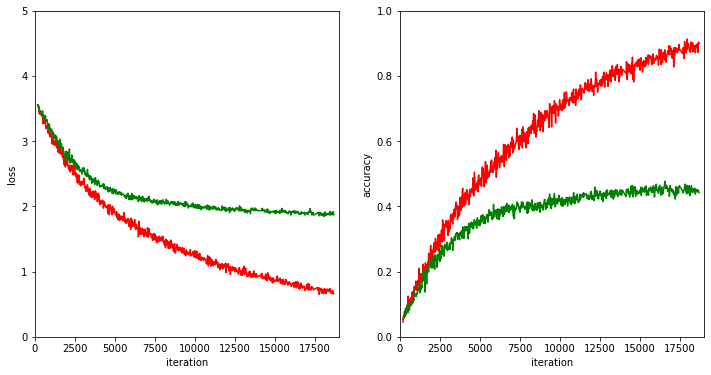

In [11]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,19000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,19000)
acc_graph.set_ylim(0,1)

plt.show() 

### Saving the top 5 

In [12]:
saved_models

[{'current_model': PetCNN6(
    (conv1): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv2): Sequential(
      (0): Dropout2d(p=0.2, inplace=False)
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
    )
    (conv3): Sequential(
      (0): Dropout2d(p=0.3, inplace=False)
      (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
    )
    (conv4): Sequential(
    

In [13]:
def save_model(n):
    """
    n is the index of the model in the list saved_models. We'll have filenames that tell you the epoch, for example, B2_3675.pt
    """
    
    torch.save(saved_models[n]['current_model'].state_dict(),'models/L/L_' + str(saved_models[n]['current_iter']) + '.pt')

In [14]:
for n in range(5):
    save_model(n)

In [15]:
modelt = PetCNN6()                        
model.load_state_dict(torch.load('models/L/L_16575.pt'))
model.eval()

valid_e = next(iter(valid_loader))
valid_o = model(valid_e[0].float())
valid_loss = loss_function(valid_o,valid_e[1])
valid_accuracy = (torch.max(valid_o,1)[1]==valid_e[1]).sum()/len(valid)

print('validation loss:{}'.format(valid_loss))
print('validation accuracy:{}'.format(valid_accuracy))

validation loss:1.8890336751937866
validation accuracy:0.4711643159389496
